<h1 style="font-family:'Times New Roman'; font-size:32px;">
<b>Threshold-Based Segmentation of Brain MRI Images</b>
</h1>

<p style="font-family:'Times New Roman'; font-size:16px;">
<b>Description:</b><br>
This project explores classical threshold-based segmentation techniques on a brain MRI slice.
The aim is to analyze and compare <b>global thresholding</b>, <b>adaptive thresholding</b>,
<b>contrast enhancement</b>, and <b>region splitting &amp; merging</b>, highlighting their strengths
and limitations for medical image visualization.
</p>

<p style="font-family:'Times New Roman'; font-size:16px;">
<b>Authors:</b> Ilaria Coccollone, Andrea Matteo Re
</p>

<p style="font-family:'Times New Roman'; font-size:16px;">
<b>Date:</b> 29 January 2026
</p>


<p style="font-family:'Times New Roman'; font-size:16px;">
<b>Required Packages:</b> The notebook uses Python libraries for loading and processing medical images, enhancing image contrast, performing global, multi-level, and adaptive thresholding, applying morphological post-processing, and visualizing images and quantitative results.
</p>


In [1]:
## Library for loading and handling medical imaging data in NIfTI format
import nibabel as nib

# Fundamental package for numerical computations and array manipulation
import numpy as np

# Nilearn module for visualization of neuroimaging data
from nilearn import plotting

# Functions for image contrast enhancement and intensity manipulation
from skimage import exposure

# Library for creating plots and visualizing images and histograms
import matplotlib.pyplot as plt

# Class for creating custom colormaps for image visualization
from matplotlib.colors import ListedColormap

# Global Otsu thresholding method
from skimage.filters import threshold_otsu

# Local adaptive thresholding method
from skimage.filters import threshold_local

# Multi Otsu thresholding for multi class segmentation
from skimage.filters import threshold_multiotsu

# Function to extract boundaries between segmented regions
from skimage.segmentation import find_boundaries

# Morphological operations for post processing binary masks
from skimage.morphology import opening, closing, disk, remove_small_objects

# Utility to print formatted tables for quantitative analysis
from tabulate import tabulate

<h2 style="font-family:'Times New Roman'; font-size:22px;">
Data Loading and Slice Selection
</h2>

<p style="font-family:'Times New Roman'; font-size:16px; text-align: justify;">
In this section the medical imaging data are loaded and a two-dimensional slice is selected for further processing and analysis.
</p>



In [2]:
# Path to the NIfTI file (.nii) containing the MRI volume
# file_nii = "C:\\Users\\andre\\OneDrive\\Desktop\\BraTS20_Training_012_t1.nii"
file_nii = "/Users/ilaria/Desktop/Advanced-computer-and-image-processing/project/BraTS20_Training_012_t1.nii"
# Load the NIfTI image using nibabel
img = nib.load(file_nii)

# Extract the image data as a NumPy array
# The resulting array contains voxel intensity values
data = img.get_fdata()

# Print basic information about the MRI volume
print("Image shape (3D volume):", data.shape)
print("Data type:", data.dtype)


Image shape (3D volume): (240, 240, 155)
Data type: float64


<h2 style="font-family:'Times New Roman'; font-size:22px;">
Image Preprocessing and Contrast Enhancement
</h2>

<p style="font-family:'Times New Roman'; font-size:16px; text-align: justify;">
This section applies basic preprocessing steps, including data type conversion and histogram equalization, to improve image contrast and intensity distribution.
</p>

In [3]:
from skimage.filters import gaussian

volume_3d = data
# Intensity normalization
vol_min = volume_3d.min()
vol_max = volume_3d.max()
volume_norm = (volume_3d - vol_min) / (vol_max - vol_min)

# Gaussian smoothing
volume_smooth = gaussian(volume_norm, sigma=1)
data=volume_smooth

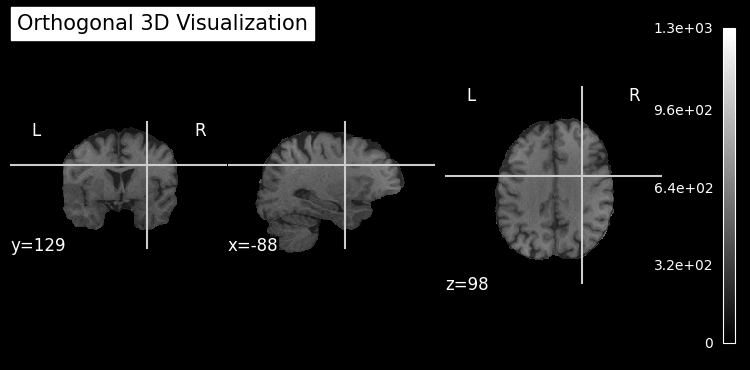

In [4]:
# Display the MRI volume in three orthogonal planes
plotting.plot_anat(img, display_mode="ortho", title="Orthogonal 3D Visualization")

# Show the figure
plotting.show()

In [5]:
# Extract the image data as a NumPy array
data = img.get_fdata()

# Select the central slice along the z-axis (common practice for 2D analysis)
z = data.shape[2] // 2
slice_img = data[:, :, z]

# Print the shape of the 2D slice
print(slice_img.shape)

(240, 240)


<h2 style="font-family:'Times New Roman'; font-size:22px;">
Global Otsu Thresholding
</h2>

<p style="font-family:'Times New Roman'; font-size:16px; text-align: justify;">
This section applies global Otsu thresholding to segment the image into background and foreground regions and computes basic quantitative metrics.
</p>

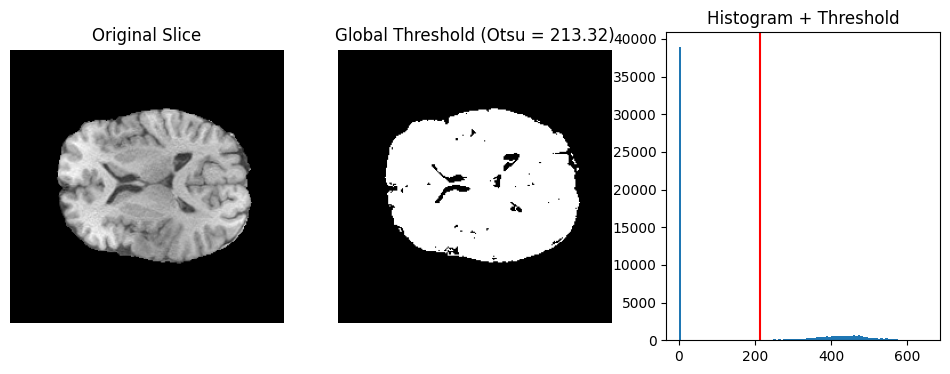

In [6]:
# Compute Otsu's global threshold
th = threshold_otsu(slice_img)

# Apply threshold to create a binary image
binary_global = slice_img > th

# Plot original slice, binary mask, and histogram with threshold
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(slice_img, cmap="gray")
plt.title("Original Slice")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(binary_global, cmap="gray")
plt.title(f"Global Threshold (Otsu = {th:.2f})")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.hist(slice_img.flatten(), bins=100)
plt.axvline(th, color='r')
plt.title("Histogram + Threshold")

plt.show()


<h2 style="font-family:'Times New Roman'; font-size:22px;">
Multi-Level Otsu Segmentation
</h2>

<p style="font-family:'Times New Roman'; font-size:16px; text-align: justify;">
This section applies Multi-Otsu thresholding to divide the image into multiple intensity-based regions and analyzes voxel distribution across classes.
</p>

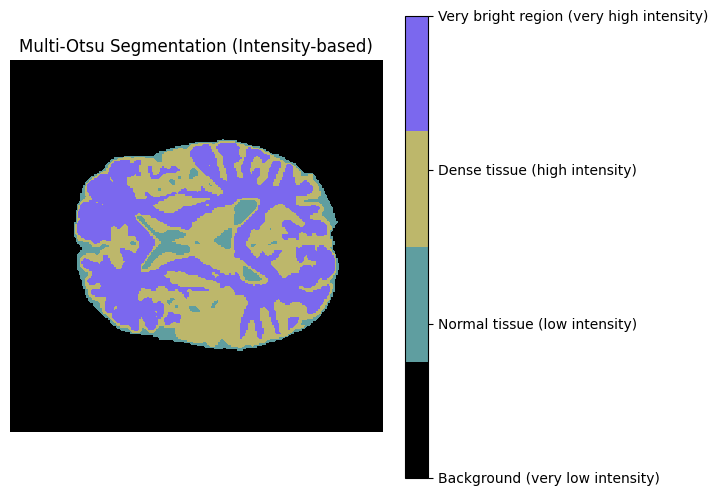

In [7]:
# Multi-Otsu segmentation (4 classes)
thresholds = threshold_multiotsu(volume_smooth, classes=4)
segmented = np.digitize(volume_smooth, bins=thresholds)

# Color map ordered by increasing intensity
# dark → low intensity, bright → high intensity
cmap = ListedColormap([
    "black",        # very low intensity
    "cadetblue",         # low intensity
    "darkkhaki",         # high intensity
    "mediumslateblue"    # very high intensity
])


# Visualize central slice
z = volume_smooth.shape[2] // 2

plt.figure(figsize=(6,6))
plt.imshow(segmented[:, :, z], cmap=cmap)
plt.title("Multi-Otsu Segmentation (Intensity-based)")
plt.axis("off")

# Colorbar with semantic meaning
cbar = plt.colorbar(ticks=[0,1,2,3])
cbar.ax.set_yticklabels([
    "Background (very low intensity)",
    "Normal tissue (low intensity)",
    "Dense tissue (high intensity)",
    "Very bright region (very high intensity)"
])
plt.show()


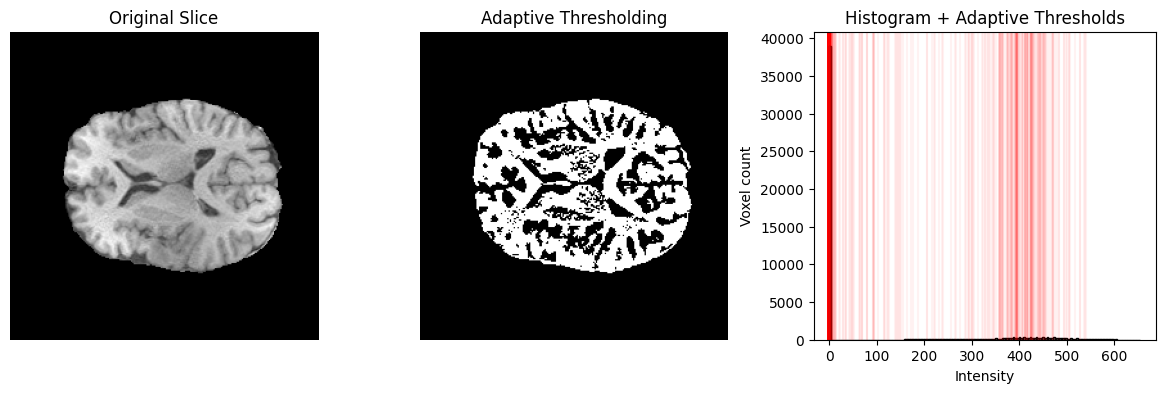

In [8]:
# Load 3D MRI and select a central slice
volume_3d = img.get_fdata()
z = volume_3d.shape[2] // 2
slice_img = volume_3d[:, :, z]

# Apply adaptive thresholding
block_size = 35
local_thresh = threshold_local(slice_img, block_size)
binary_adaptive = slice_img > local_thresh

# Display the original slice, adaptive mask, and histogram
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(slice_img, cmap="gray")
plt.title("Original Slice")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(binary_adaptive, cmap="gray")
plt.title("Adaptive Thresholding")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.hist(slice_img.flatten(), bins=200, color='gray', edgecolor='black')
plt.title("Histogram + Adaptive Thresholds")
plt.xlabel("Intensity")
plt.ylabel("Voxel count")

# Show sampled local thresholds on the histogram
sampled_thresh = local_thresh[::10, ::10].flatten()
for t in sampled_thresh:
    plt.axvline(t, color='r', alpha=0.05)

plt.show()

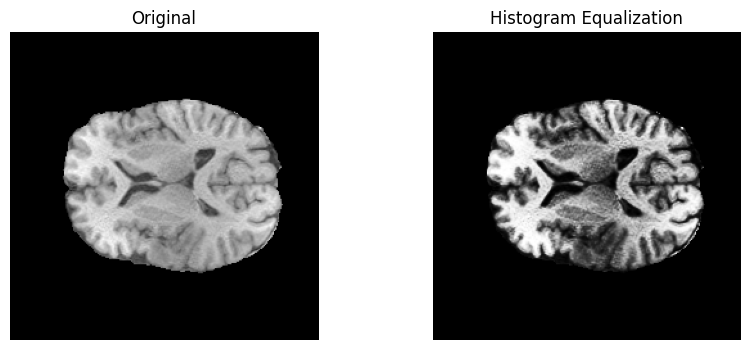

In [9]:
# Apply histogram equalization to enhance contrast
slice_eq = exposure.equalize_hist(slice_img)

# Display original and equalized slices
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(slice_img, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(slice_eq, cmap="gray")
plt.title("Histogram Equalization")
plt.axis("off")

plt.show()

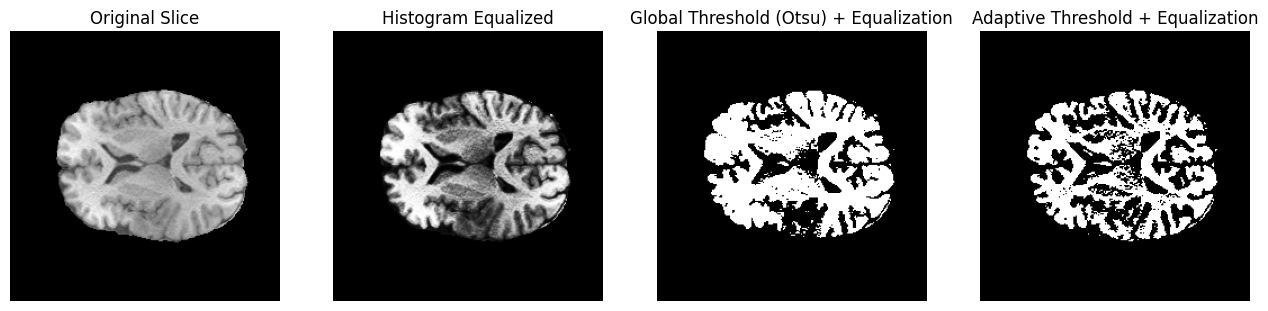

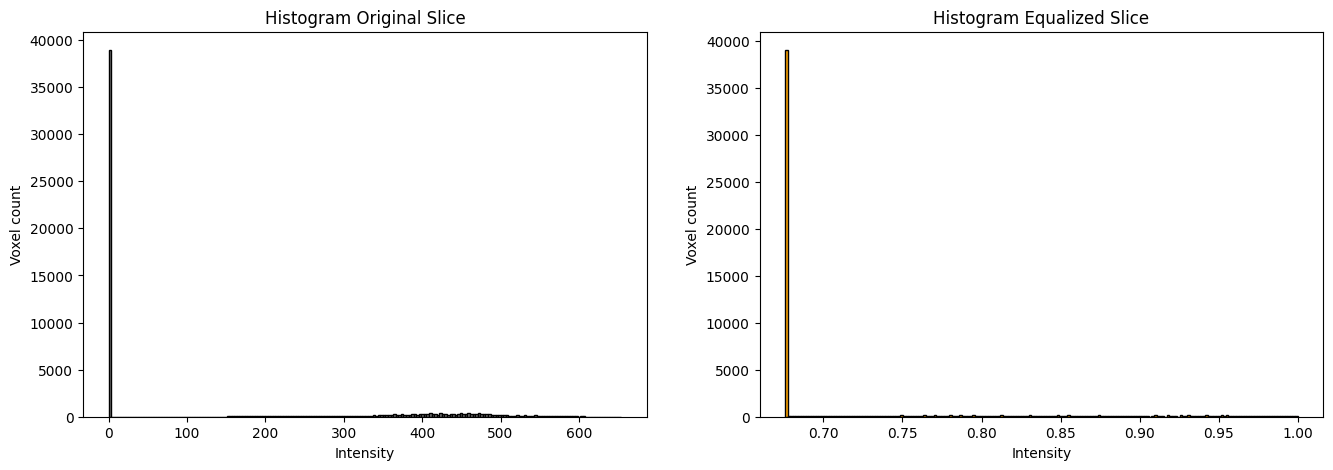

In [10]:
# Load 3D MRI volume and select a central slice
volume_3d = img.get_fdata()
z = volume_3d.shape[2] // 2
slice_img = volume_3d[:, :, z]

# Apply histogram equalization to improve contrast
slice_eq = exposure.equalize_hist(slice_img)

# Global thresholding (Otsu) after equalization
th_eq = threshold_otsu(slice_eq)
binary_eq = slice_eq > th_eq

# Adaptive thresholding after equalization
block_size = 35
local_thresh = threshold_local(slice_eq, block_size)
binary_adaptive = slice_eq > local_thresh

# Display original, equalized, and thresholded slices
plt.figure(figsize=(16,5))
plt.subplot(1,4,1)
plt.imshow(slice_img, cmap="gray")
plt.title("Original Slice")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(slice_eq, cmap="gray")
plt.title("Histogram Equalized")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(binary_eq, cmap="gray")
plt.title("Global Threshold (Otsu) + Equalization")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(binary_adaptive, cmap="gray")
plt.title("Adaptive Threshold + Equalization")
plt.axis("off")
plt.show()

# Compare histograms of original and equalized slices
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.hist(slice_img.flatten(), bins=200, color='gray', edgecolor='black')
plt.title("Histogram Original Slice")
plt.xlabel("Intensity")
plt.ylabel("Voxel count")

plt.subplot(1,2,2)
plt.hist(slice_eq.flatten(), bins=200, color='orange', edgecolor='black')
plt.title("Histogram Equalized Slice")
plt.xlabel("Intensity")
plt.ylabel("Voxel count")
plt.show()

<h2 style="font-family:'Times New Roman'; font-size:22px;">
Adaptive Local Thresholding
</h2>

<p style="font-family:'Times New Roman'; font-size:16px; text-align: justify;">
This section performs adaptive thresholding to handle local intensity variations and computes foreground and background statistics.
</p>


In [11]:
# Adaptive Thresholding: separate foreground and background
block_size = 35
local_thresh = threshold_local(slice_img, block_size)
binary_adaptive = slice_img > local_thresh  # foreground mask

# Extract voxel intensities for foreground and background
foreground = slice_img[binary_adaptive]
background = slice_img[~binary_adaptive]

# Compute basic statistics
mean_fg = np.mean(foreground)
var_fg = np.var(foreground)
mean_bg = np.mean(background)
var_bg = np.var(background)

# Print results
print("=== Foreground ===")
print(f"Mean = {mean_fg:.2f}, Variance = {var_fg:.2f}, N voxels = {len(foreground)}")

print("\n=== Background ===")
print(f"Mean = {mean_bg:.2f}, Variance = {var_bg:.2f}, N voxels = {len(background)}")

# Compare foreground vs background
print(f"\nForeground/Background mean ratio = {mean_fg/mean_bg:.2f}")
print(f"Foreground/Background variance ratio = {var_fg/var_bg:.2f}")

=== Foreground ===
Mean = 452.56, Variance = 5567.26, N voxels = 12358

=== Background ===
Mean = 46.82, Variance = 14519.60, N voxels = 45242

Foreground/Background mean ratio = 9.67
Foreground/Background variance ratio = 0.38


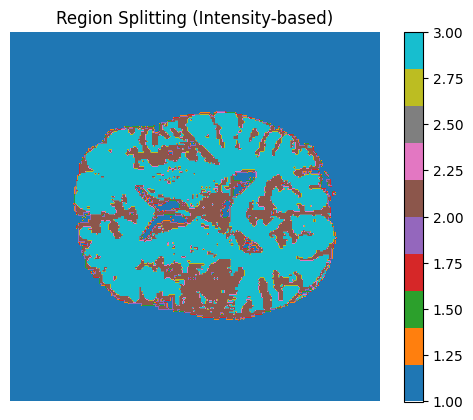

In [12]:
# Create an empty array for regions
regions = np.zeros_like(slice_img)

# Assign regions based on intensity thresholds
regions[slice_img < 0.3*np.max(slice_img)] = 1
regions[(slice_img >= 0.3*np.max(slice_img)) &
        (slice_img < 0.6*np.max(slice_img))] = 2
regions[slice_img >= 0.6*np.max(slice_img)] = 3

# Display the segmented regions
plt.imshow(regions, cmap="tab10")
plt.title("Region Splitting (Intensity-based)")
plt.colorbar()
plt.axis("off")
plt.show()

=== Region Splitting ===
Region 1: Mean=273.33, Var=3394.73, N=3814
Region 2: Mean=403.49, Var=751.27, N=7551
Region 3: Mean=499.35, Var=1444.36, N=7040
Region 4: Mean=611.61, Var=120.81, N=148


(-0.5, 239.5, 239.5, -0.5)

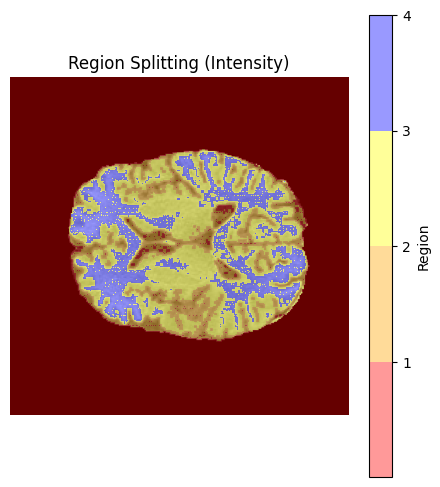

In [13]:
# Load 3D MRI and select central slice
volume_3d = img.get_fdata()
z = volume_3d.shape[2] // 2
slice_img = volume_3d[:, :, z]

# Region splitting into 4 intensity-based regions
th1, th2, th3, th4 = 150, 350, 450, 600
regions = np.zeros_like(slice_img)

regions[(slice_img >= th1) & (slice_img < th2)] = 1
regions[(slice_img >= th2) & (slice_img < th3)] = 2
regions[(slice_img >= th3) & (slice_img < th4)] = 3
regions[slice_img >= th4] = 4

# Compute basic statistics per region
print("=== Region Splitting ===")
for r in range(1, 5):
    vox = slice_img[regions == r]
    print(f"Region {r}: Mean={np.mean(vox):.2f}, Var={np.var(vox):.2f}, N={len(vox)}")


# Visualization of results
plt.figure(figsize=(12,6))

# Region splitting overlay
plt.subplot(1,2,1)
plt.imshow(slice_img, cmap='gray')
cmap_regions = ListedColormap(['red','orange','yellow','blue'])
plt.imshow(regions, cmap=cmap_regions, alpha=0.4)
plt.colorbar(ticks=[1,2,3,4], label="Region")
plt.title("Region Splitting (Intensity)")
plt.axis("off")



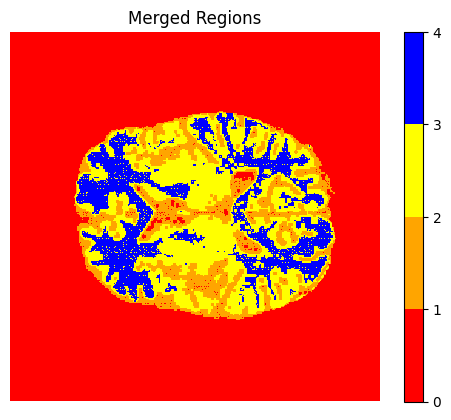

In [14]:
# Load 3D MRI and select central slice
volume_3d = img.get_fdata()
z = volume_3d.shape[2] // 2
slice_img = volume_3d[:, :, z]

# Region splitting into 4 intensity-based regions
th1, th2, th3, th4 = 150, 350, 450, 600
regions = np.zeros_like(slice_img)
regions[(slice_img >= th1) & (slice_img < th2)] = 1
regions[(slice_img >= th2) & (slice_img < th3)] = 2
regions[(slice_img >= th3) & (slice_img < th4)] = 3
regions[slice_img >= th4] = 4

# Variance map per regione (necessario per il merge)
var_map = np.zeros_like(slice_img)
for r in np.unique(regions):
    mask = regions == r
    var_map[mask] = np.var(slice_img[mask])

# Merge regions with similar mean and variance
merged = regions.copy()
labels = np.unique(merged)

# Thresholds
th_mean = 0.2 * np.max(slice_img)
th_var  = 0.1 * np.max(var_map)

# Statistics per region
stats = {}
for l in labels:
    mask = merged == l
    stats[l] = {
        'mean': np.mean(slice_img[mask]),
        'var': np.var(slice_img[mask])
    }

# Compare region pairs and merge if similar
for i in labels:
    for j in labels:
        if i >= j:
            continue
        if (abs(stats[i]['mean'] - stats[j]['mean']) < th_mean) and \
           (abs(stats[i]['var']  - stats[j]['var'])  < th_var):
            merged[merged == j] = i

# Visualize merged regions
plt.imshow(merged, cmap=ListedColormap(['red','orange','yellow','blue']))
plt.title("Merged Regions")
plt.colorbar(ticks=np.unique(merged))
plt.axis("off")
plt.show()


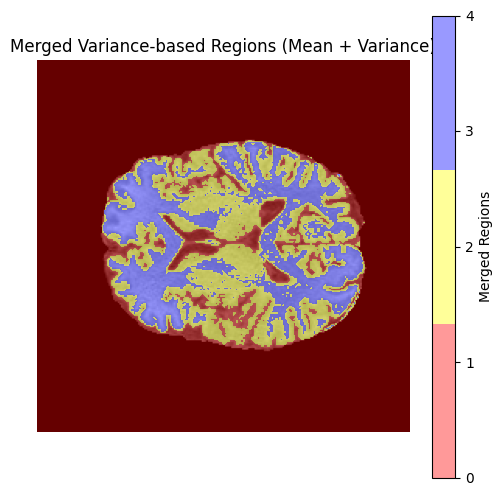

In [15]:
plt.figure(figsize=(6,6))

# Display the original MRI slice in grayscale
plt.imshow(slice_img, cmap='gray')

# Overlay the merged regions with transparency
cmap_merged = ListedColormap(['red','yellow','blue'])
plt.imshow(merged, cmap=cmap_merged, alpha=0.4)

# Add a colorbar showing the merged region labels
plt.colorbar(ticks=np.unique(merged), label="Merged Regions")

# Set the title
plt.title("Merged Variance-based Regions (Mean + Variance)")

# Remove axis ticks
plt.axis("off")

# Show the plot
plt.show()

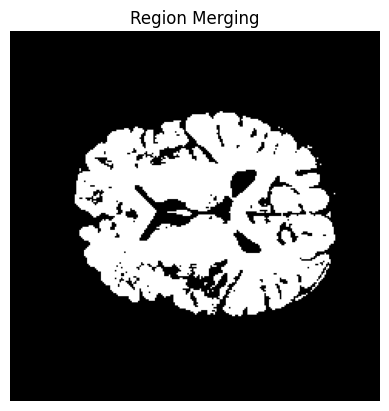

In [16]:
# Create a new array for merged regions
# Combine regions 2 and 3 into a single merged region labeled as 1
merged = np.zeros_like(regions)
merged[(regions == 2) | (regions == 3)] = 1

# Display the merged regions in grayscale
plt.imshow(merged, cmap="gray")
plt.title("Region Merging")
plt.axis("off")
plt.show()

<h2 style="font-family:'Times New Roman'; font-size:22px;">
Morphological Post-Processing
</h2>

<p style="font-family:'Times New Roman'; font-size:16px; text-align: justify;">
This section applies morphological operations to clean the segmentation masks and reduce noise while preserving relevant anatomical structures.
</p>

In [17]:
# Convert the selected slice to float for further processing
slice_img = slice_img.astype(np.float32)

# Apply histogram equalization to enhance image contrast
slice_eq = exposure.equalize_hist(slice_img)

# Function to perform global Otsu thresholding and compute basic statistics
def otsu_analysis(img):
    th = threshold_otsu(img)
    mask = img > th
    bg_vox = np.sum(mask == 0)
    fg_vox = np.sum(mask == 1)
    perc_fg = fg_vox / img.size * 100
    return mask, th, bg_vox, fg_vox, perc_fg

# Otsu analysis on original and equalized images
mask_otsu_orig, th_otsu_orig, bg_otsu_orig, fg_otsu_orig, perc_fg_otsu_orig = otsu_analysis(slice_img)
mask_otsu_eq, th_otsu_eq, bg_otsu_eq, fg_otsu_eq, perc_fg_otsu_eq = otsu_analysis(slice_eq)

# Function to perform Multi-Otsu segmentation and compute voxel statistics
def multiotsu_analysis(img, classes=4):
    thresholds = threshold_multiotsu(img, classes=classes)
    segmented = np.digitize(img, bins=thresholds)
    vox_counts = [np.sum(segmented == c) for c in range(classes)]
    perc_volume = [v / img.size * 100 for v in vox_counts]
    fg_vox = img.size - vox_counts[0]
    return segmented, thresholds, vox_counts, perc_volume, fg_vox

# Multi-Otsu analysis on original and equalized images
seg_orig, th_multi_orig, vox_multi_orig, perc_multi_orig, fg_multi_orig = multiotsu_analysis(slice_img)
seg_eq, th_multi_eq, vox_multi_eq, perc_multi_eq, fg_multi_eq = multiotsu_analysis(slice_eq)

# Block size used for adaptive local thresholding
block_size = 35

# Function to perform adaptive thresholding and compute basic statistics
def adaptive_analysis(img, block_size):
    local_th = threshold_local(img, block_size)
    mask = img > local_th
    bg_vox = np.sum(mask == 0)
    fg_vox = np.sum(mask == 1)
    perc_fg = fg_vox / img.size * 100
    return mask, local_th, bg_vox, fg_vox, perc_fg

# Adaptive thresholding on original and equalized images
mask_adapt_orig, local_th_orig, bg_adapt_orig, fg_adapt_orig, perc_fg_adapt_orig = adaptive_analysis(slice_img, block_size)
mask_adapt_eq, local_th_eq, bg_adapt_eq, fg_adapt_eq, perc_fg_adapt_eq = adaptive_analysis(slice_eq, block_size)

# Structuring element and minimum object size for morphological cleaning
selem = disk(1)
min_size = 10

# Morphological post-processing for binary masks
def postprocess_mask(mask, do_remove_small=True):
    clean = opening(mask, selem)
    clean = closing(clean, selem)
    if do_remove_small:
        clean = remove_small_objects(clean, min_size=min_size)
    return clean

# Post-processing for Otsu and adaptive thresholding masks
mask_otsu_orig_clean = postprocess_mask(mask_otsu_orig)
mask_otsu_eq_clean = postprocess_mask(mask_otsu_eq)

mask_adapt_orig_clean = postprocess_mask(mask_adapt_orig)
mask_adapt_eq_clean = postprocess_mask(mask_adapt_eq)

# Foreground extraction from Multi-Otsu segmentation
foreground_multi_orig = seg_orig > 0
foreground_multi_eq = seg_eq > 0

# Morphological post-processing for Multi-Otsu foreground masks
def postprocess_multi(mask):
    clean = opening(mask, selem)
    clean = closing(clean, selem)
    return clean

foreground_multi_orig_clean = postprocess_multi(foreground_multi_orig)
foreground_multi_eq_clean = postprocess_multi(foreground_multi_eq)

/var/folders/kg/6fg_6d0d2_bd24cf8gh6v2f40000gn/T/ipykernel_96402/4604769.py:58: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  clean = remove_small_objects(clean, min_size=min_size)


<h2 style="font-family:'Times New Roman'; font-size:22px;">
Quantitative Analysis
</h2>

<p style="font-family:'Times New Roman'; font-size:16px; text-align: justify;">
This section computes quantitative metrics such as background voxels, foreground voxels, and foreground percentage for all segmentation methods.
</p>


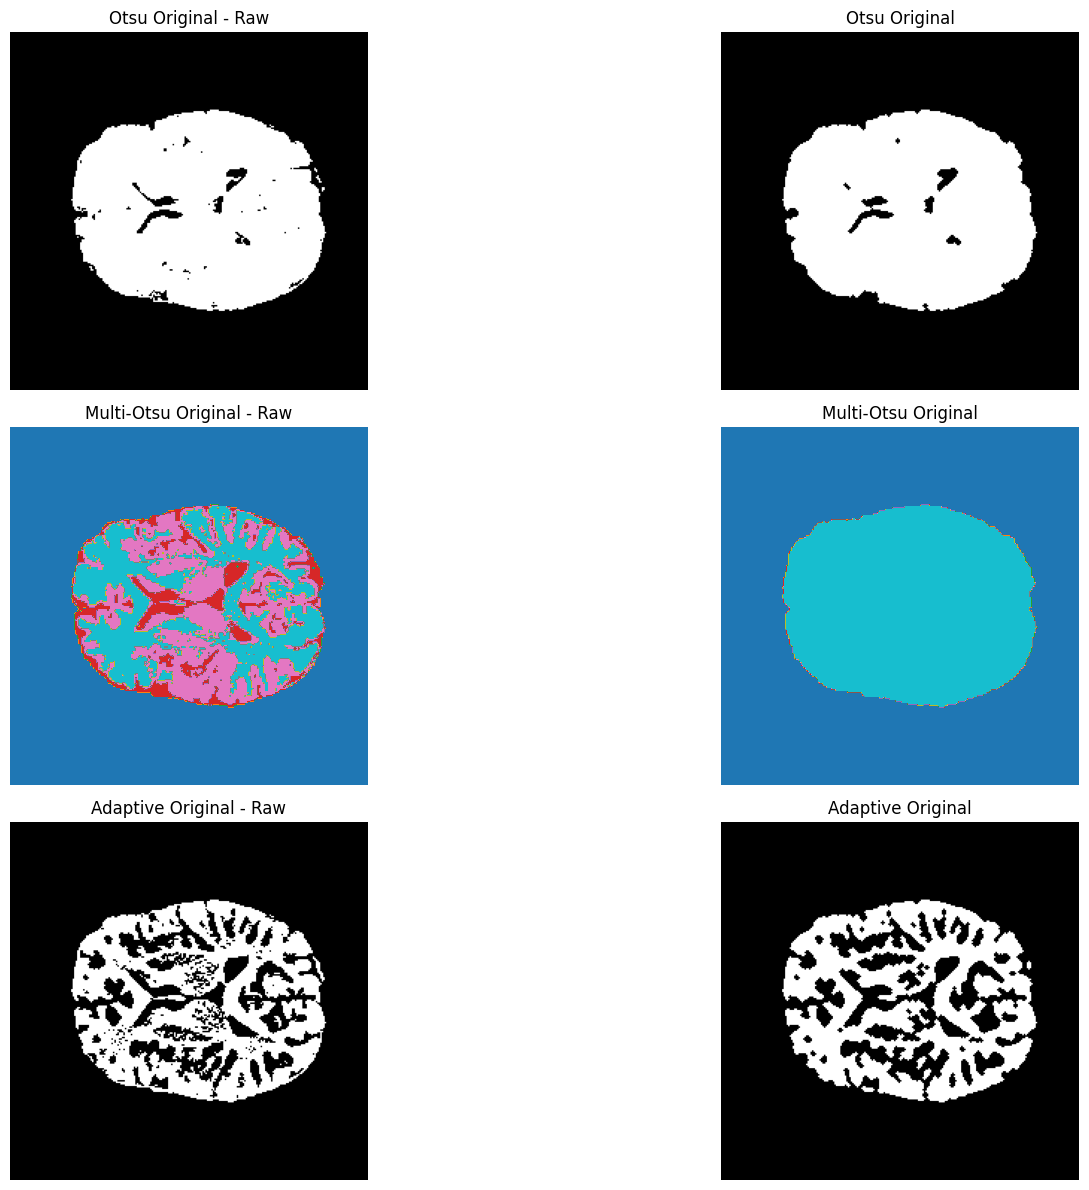

=== Global Otsu ===
| Method            |   BG Voxels |   FG Voxels | % FG   |   Threshold |
|-------------------|-------------|-------------|--------|-------------|
| Original Raw      |       39835 |       17765 | 30.84% |     213.316 |
| Original Cleaned  |       39848 |       17752 | 30.82% |     213.316 |
| Equalized Raw     |       45372 |       12228 | 21.23% |       0.789 |
| Equalized Cleaned |       45513 |       12087 | 20.98% |       0.789 |

=== Multi-Otsu (4 classes) ===
| Method            |   Class0 |   Class1 |   Class2 |   Class3 |   FG Voxels | % FG   | Thresholds                         |
|-------------------|----------|----------|----------|----------|-------------|--------|------------------------------------|
| Original Raw      |    38945 |     2582 |     8387 |     7686 |       18655 | 32.39% | [118.79297 312.94922 443.23828]    |
| Original Cleaned  |        0 |    18661 |    18661 |    18661 |       18661 | 32.40% | [118.79297 312.94922 443.23828]    |
| Equa

In [18]:
# Function to compute background and foreground statistics from a binary mask
def calc_stats(mask):
    bg = np.sum(mask == 0)
    fg = np.sum(mask == 1)
    perc_fg = fg / mask.size * 100
    return bg, fg, perc_fg

# Statistics for cleaned Otsu masks
bg_otsu_orig_c, fg_otsu_orig_c, perc_fg_otsu_orig_c = calc_stats(mask_otsu_orig_clean)
bg_otsu_eq_c, fg_otsu_eq_c, perc_fg_otsu_eq_c = calc_stats(mask_otsu_eq_clean)

# Statistics for cleaned adaptive thresholding masks
bg_adapt_orig_c, fg_adapt_orig_c, perc_fg_adapt_orig_c = calc_stats(mask_adapt_orig_clean)
bg_adapt_eq_c, fg_adapt_eq_c, perc_fg_adapt_eq_c = calc_stats(mask_adapt_eq_clean)

# Foreground statistics for cleaned Multi-Otsu masks
fg_multi_orig_c = np.sum(foreground_multi_orig_clean)
perc_fg_multi_orig_c = fg_multi_orig_c / foreground_multi_orig_clean.size * 100

fg_multi_eq_c = np.sum(foreground_multi_eq_clean)
perc_fg_multi_eq_c = fg_multi_eq_c / foreground_multi_eq_clean.size * 100

# Tables summarizing Otsu thresholding results
table_otsu = [
    ["Original Raw", bg_otsu_orig, fg_otsu_orig, f"{perc_fg_otsu_orig:.2f}%", f"{th_otsu_orig:.3f}"],
    ["Original Cleaned", bg_otsu_orig_c, fg_otsu_orig_c, f"{perc_fg_otsu_orig_c:.2f}%", f"{th_otsu_orig:.3f}"],
    ["Equalized Raw", bg_otsu_eq, fg_otsu_eq, f"{perc_fg_otsu_eq:.2f}%", f"{th_otsu_eq:.3f}"],
    ["Equalized Cleaned", bg_otsu_eq_c, fg_otsu_eq_c, f"{perc_fg_otsu_eq_c:.2f}%", f"{th_otsu_eq:.3f}"]
]

# Tables summarizing Multi-Otsu segmentation results
table_multi = [
    ["Original Raw"] + vox_multi_orig + [fg_multi_orig] + [f"{fg_multi_orig / slice_img.size * 100:.2f}%"] + [th_multi_orig],
    ["Original Cleaned"] + [0, fg_multi_orig_c, fg_multi_orig_c, fg_multi_orig_c] + [fg_multi_orig_c] + [f"{perc_fg_multi_orig_c:.2f}%"] + [th_multi_orig],
    ["Equalized Raw"] + vox_multi_eq + [fg_multi_eq] + [f"{fg_multi_eq / slice_img.size * 100:.2f}%"] + [th_multi_eq],
    ["Equalized Cleaned"] + [0, fg_multi_eq_c, fg_multi_eq_c, fg_multi_eq_c] + [fg_multi_eq_c] + [f"{perc_fg_multi_eq_c:.2f}%"] + [th_multi_eq]
]

# Tables summarizing adaptive thresholding results
table_adapt = [
    ["Original Raw", bg_adapt_orig, fg_adapt_orig, f"{perc_fg_adapt_orig:.2f}%"],
    ["Original Cleaned", bg_adapt_orig_c, fg_adapt_orig_c, f"{perc_fg_adapt_orig_c:.2f}%"],
    ["Equalized Raw", bg_adapt_eq, fg_adapt_eq, f"{perc_fg_adapt_eq:.2f}%"],
    ["Equalized Cleaned", bg_adapt_eq_c, fg_adapt_eq_c, f"{perc_fg_adapt_eq_c:.2f}%"]
]

# Visualization of segmentation results
plt.figure(figsize=(18, 12))

# Otsu thresholding results
plt.subplot(3, 2, 1)
plt.imshow(mask_otsu_orig, cmap="gray")
plt.title("Otsu Original - Raw")
plt.axis("off")

plt.subplot(3, 2, 2)
plt.imshow(mask_otsu_orig_clean, cmap="gray")
plt.title("Otsu Original")
plt.axis("off")

# Multi-Otsu segmentation results
plt.subplot(3, 2, 3)
plt.imshow(seg_orig, cmap="tab10")
plt.title("Multi-Otsu Original - Raw")
plt.axis("off")

plt.subplot(3, 2, 4)
plt.imshow(foreground_multi_orig_clean, cmap="tab10")
plt.title("Multi-Otsu Original")
plt.axis("off")

# Adaptive thresholding results
plt.subplot(3, 2, 5)
plt.imshow(mask_adapt_orig, cmap="gray")
plt.title("Adaptive Original - Raw")
plt.axis("off")

plt.subplot(3, 2, 6)
plt.imshow(mask_adapt_orig_clean, cmap="gray")
plt.title("Adaptive Original")
plt.axis("off")

plt.tight_layout()
plt.show()

# Print quantitative result tables
print("=== Global Otsu ===")
print(tabulate(table_otsu,
               headers=["Method", "BG Voxels", "FG Voxels", "% FG", "Threshold"],
               tablefmt="github"))

print("\n=== Multi-Otsu (4 classes) ===")
print(tabulate(table_multi,
               headers=["Method", "Class0", "Class1", "Class2", "Class3", "FG Voxels", "% FG", "Thresholds"],
               tablefmt="github"))

print("\n=== Adaptive Threshold ===")
print(tabulate(table_adapt,
               headers=["Method", "BG Voxels", "FG Voxels", "% FG"],
               tablefmt="github"))

<h2 style="font-family:'Times New Roman'; font-size:22px;">
Discussion and Conclusions
</h2>

<p style="font-family:'Times New Roman'; font-size:16px; text-align: justify;">
The comparison between global, multi-level, and adaptive thresholding highlights their strengths and limitations in brain MRI segmentation.  
Histogram equalization and morphological post-processing significantly improve segmentation stability and foreground consistency.
</p>